In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
from datetime import datetime

In [4]:
def generate_dates(from_day, to_day):
    return [pd.to_datetime(x).date() for x in pd.date_range(from_day, to_day, freq='D').values]

In [5]:
initial_dates = generate_dates('1960-01-01', '1961-12-31')
pairs = []
for d in initial_dates:
    pair = [d.strftime('%d %B, %Y'), d.strftime('%d %b %Y')]
    pairs.append(pair)

In [6]:
pairs[:10]

[['01 January, 1960', '01 Jan 1960'],
 ['02 January, 1960', '02 Jan 1960'],
 ['03 January, 1960', '03 Jan 1960'],
 ['04 January, 1960', '04 Jan 1960'],
 ['05 January, 1960', '05 Jan 1960'],
 ['06 January, 1960', '06 Jan 1960'],
 ['07 January, 1960', '07 Jan 1960'],
 ['08 January, 1960', '08 Jan 1960'],
 ['09 January, 1960', '09 Jan 1960'],
 ['10 January, 1960', '10 Jan 1960']]

In [7]:
tofile = ""
for pair in pairs:
    strf = "{}\t{}\n".format(pair[0], pair[1])
    tofile += strf
with open('/Users/flint/GitHub/textsent/insights/language-models/translate/date1-date3.txt', 'w') as out:
    out.write(tofile)


# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)

This tutorial is almost identical to the [PyTorch version](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). We just substitute to sentences the date formats and we use characters sequences instead of word sequences.

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

In [9]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "@", 1: "#"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/Users/flint/GitHub/textsent/insights/language-models/translate/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('date1', 'date3', False)
print(random.choice(pairs))

Reading lines...
Read 731 sentence pairs
Counting words...
Counted words:
date1 40
date3 35
['10 December, 1960', '10 Dec 1960']


In [12]:
output_lang.index2word

{0: '@',
 1: '#',
 2: '0',
 3: '1',
 4: ' ',
 5: 'J',
 6: 'a',
 7: 'n',
 8: '9',
 9: '6',
 10: '2',
 11: '3',
 12: '4',
 13: '5',
 14: '7',
 15: '8',
 16: 'F',
 17: 'e',
 18: 'b',
 19: 'M',
 20: 'r',
 21: 'A',
 22: 'p',
 23: 'y',
 24: 'u',
 25: 'l',
 26: 'g',
 27: 'S',
 28: 'O',
 29: 'c',
 30: 't',
 31: 'N',
 32: 'o',
 33: 'v',
 34: 'D'}

## The Seq2Seq Model

### The Encoder

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
MAX_LENGTH = 20

#### Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
t1, t2 = tensorsFromPair(pairs[0])

In [19]:
t1

tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 6],
        [ 9],
        [10],
        [11],
        [ 4],
        [ 3],
        [12],
        [13],
        [ 2],
        [ 1]])

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
        decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                    for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [23]:
import matplotlib.pyplot as plt
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

0m 4s (- 0m 43s) (200 10%) 2.2758
0m 8s (- 0m 34s) (400 20%) 1.3307
0m 12s (- 0m 29s) (600 30%) 0.8931
0m 16s (- 0m 24s) (800 40%) 0.7111
0m 20s (- 0m 20s) (1000 50%) 0.5647
0m 24s (- 0m 16s) (1200 60%) 0.3216
0m 28s (- 0m 12s) (1400 70%) 0.1598
0m 32s (- 0m 8s) (1600 80%) 0.0781
0m 37s (- 0m 4s) (1800 90%) 0.0351
0m 41s (- 0m 0s) (2000 100%) 0.0193


<Figure size 640x480 with 0 Axes>

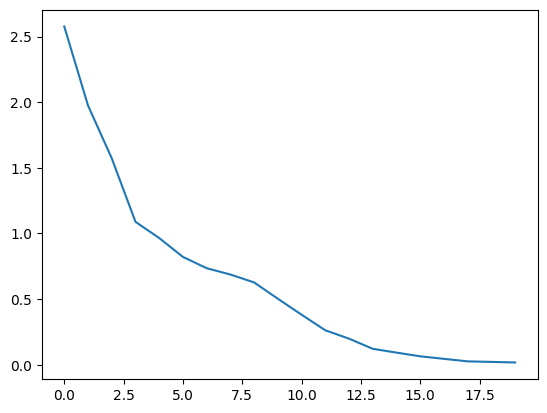

In [26]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 2000, print_every=200)

In [27]:
evaluateRandomly(encoder1, attn_decoder1)

> 16 December, 1960
= 16 Dec 1960
< 16 Dec 1960<EOS>

> 16 November, 1961
= 16 Nov 1961
< 16 Nov 1961<EOS>

> 20 March, 1960
= 20 Mar 1960
< 20 Mar 1960<EOS>

> 27 May, 1961
= 27 May 1961
< 27 May 1961<EOS>

> 06 January, 1960
= 06 Jan 1960
< 06 Jan 1960<EOS>

> 27 February, 1961
= 27 Feb 1961
< 27 Feb 1961<EOS>

> 28 January, 1961
= 28 Jan 1961
< 28 Jan 1961<EOS>

> 13 May, 1960
= 13 May 1960
< 13 May 1960<EOS>

> 02 April, 1961
= 02 Apr 1961
< 02 Apr 1961<EOS>

> 18 October, 1961
= 18 Oct 1961
< 18 Oct 1961<EOS>



### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




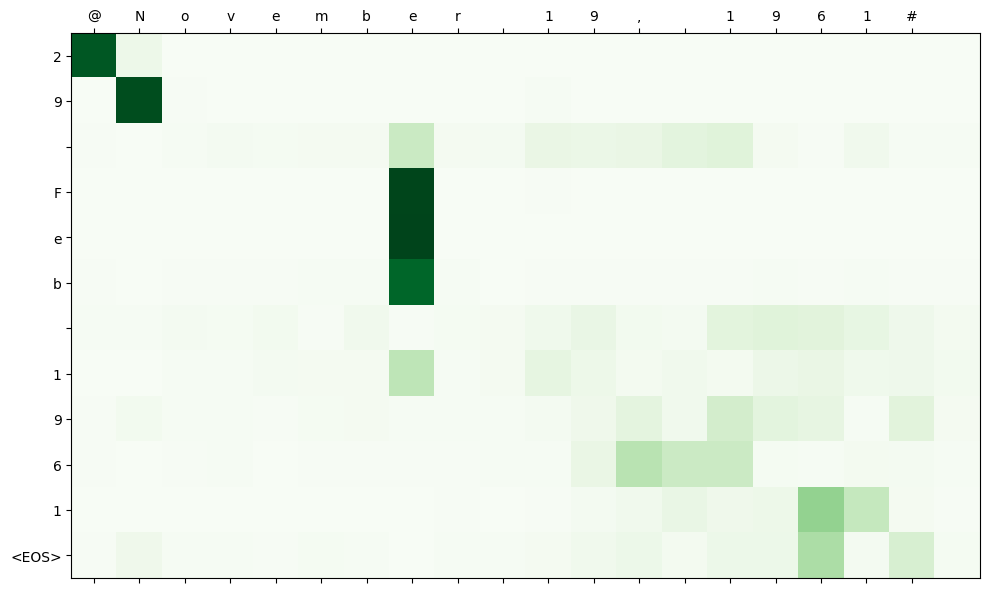

In [28]:
input_date = "November 19, 1961"
fig, ax = plt.subplots(figsize=(10, 10))
output_words, attentions = evaluate(
    encoder1, attn_decoder1, input_date)
ax.matshow(attentions.numpy(), cmap='Greens')
ax.set_xticks(range(len(input_date) + 2))
ax.set_xticklabels(['@'] + [x for x in input_date] + ['#'])
ax.set_yticks(range(len(output_words)))
ax.set_yticklabels([x for x in output_words])
plt.tight_layout()
plt.show()